## 开始对ae代码在鸢尾花，mnist数据集上进行torch的调优

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [55]:
BATCH_SIZE=512 #大概需要2G的显存
EPOCHS=20 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU，建议使用GPU环境，因为会快很多
print(DEVICE)

cuda


In [14]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

In [15]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

## Helper Function

In [25]:
def to_img(x):
    x = x.data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model, save=True, name=None, conv=False, simple=False):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    if not conv:
        data = data.view([-1, 784])
    data = Variable(data, volatile=True)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    if simple:
        encoded_imgs = F.relu(encoded_imgs)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if save:
        plt.savefig('./plots/' + name + '.png', format='png', dpi=300)
    plt.show()
    

def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()


def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()
def prepare_input_data(X):
    X = np.asarray(X)
    if X.dtype != "f" and X.dtype != "d":
        X = X.astype(float)
    missing_mask = np.isnan(X)
    return X, missing_mask
def l1_penalty(var):
    return torch.abs(var).sum()

In [26]:
class Autoencoder(nn.Module):
    def __init__(self, dim,theta):
        super(Autoencoder, self).__init__()
        self.dim = dim

        self.drop_out = nn.Dropout(p=0.1)

        self.encoder = nn.Sequential(
            nn.Linear(dim + theta * 0, dim + theta * 1),
            nn.Tanh(),
            nn.Linear(dim + theta * 1, dim + theta * 2),
            nn.Tanh(),
            nn.Linear(dim + theta * 2, dim + theta * 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim + theta * 3, dim + theta * 2),
            nn.Tanh(),
            nn.Linear(dim + theta * 2, dim + theta * 1),
            nn.Tanh(),
            nn.Linear(dim + theta * 1, dim + theta * 0)
        )

    def forward(self, x):
        x = x.view(-1, self.dim)
        x_missed = self.drop_out(x)

        z = self.encoder(x_missed)
        out = self.decoder(z)

        out = out.view(-1, self.dim)

        return out,z

In [27]:
n_features= 784
theta=10
model=Autoencoder(dim=n_features,theta=theta)
optimizer = optim.Adam(model.parameters())

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.019390
Train Epoch: 1 [25600/60000 (42%)]	Loss: 0.019706
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.019738
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.019698
Train Epoch: 2 [25600/60000 (42%)]	Loss: 0.018956
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.019361
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019231
Train Epoch: 3 [25600/60000 (42%)]	Loss: 0.019149
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.019615
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019428
Train Epoch: 4 [25600/60000 (42%)]	Loss: 0.019322
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.019125
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.019308
Train Epoch: 5 [25600/60000 (42%)]	Loss: 0.019598
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.019368
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.019272
Train Epoch: 6 [25600/60000 (42%)]	Loss: 0.019354
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.019408
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.019510
Train Epoch: 7 [25600/60000 (42%)]	Loss: 0.019726
Train Epoch: 7 [51200/60000 (85%)]	

Train Epoch: 56 [51200/60000 (85%)]	Loss: 0.019384
Train Epoch: 57 [0/60000 (0%)]	Loss: 0.019001
Train Epoch: 57 [25600/60000 (42%)]	Loss: 0.019712
Train Epoch: 57 [51200/60000 (85%)]	Loss: 0.019070
Train Epoch: 58 [0/60000 (0%)]	Loss: 0.019180
Train Epoch: 58 [25600/60000 (42%)]	Loss: 0.018961
Train Epoch: 58 [51200/60000 (85%)]	Loss: 0.019269
Train Epoch: 59 [0/60000 (0%)]	Loss: 0.019843
Train Epoch: 59 [25600/60000 (42%)]	Loss: 0.019105
Train Epoch: 59 [51200/60000 (85%)]	Loss: 0.019319
Train Epoch: 60 [0/60000 (0%)]	Loss: 0.019168
Train Epoch: 60 [25600/60000 (42%)]	Loss: 0.019280
Train Epoch: 60 [51200/60000 (85%)]	Loss: 0.019577
Train Epoch: 61 [0/60000 (0%)]	Loss: 0.019520
Train Epoch: 61 [25600/60000 (42%)]	Loss: 0.019419
Train Epoch: 61 [51200/60000 (85%)]	Loss: 0.019660
Train Epoch: 62 [0/60000 (0%)]	Loss: 0.019029
Train Epoch: 62 [25600/60000 (42%)]	Loss: 0.019443
Train Epoch: 62 [51200/60000 (85%)]	Loss: 0.019844
Train Epoch: 63 [0/60000 (0%)]	Loss: 0.019261
Train Epoch: 63

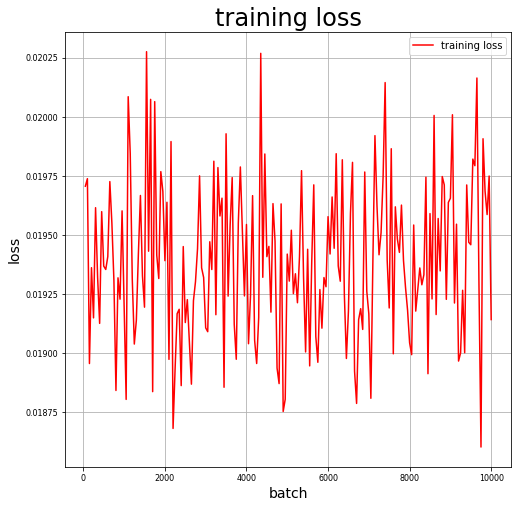

In [58]:
num_epochs = 100
Batch=0
Batchs=[]
all_train_accs=[]
all_train_loss=[]
sparsity=False
l1_weight=1e-5
for epoch in range(1,  num_epochs + 1):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.view([-1, 784]))
        optimizer.zero_grad()

        # enforcing sparsity with l1 reg
        if sparsity:
            decoder_out,encoder_out = model(data)
            mse_loss = F.mse_loss(decoder_out, data)
            l1_reg = l1_weight * l1_penalty(encoder_out)
            loss = mse_loss + l1_reg
        else:
            output,_ = model(data)
            #loss = F.binary_cross_entropy_with_logits(output, data)
            loss = F.mse_loss(output, data)
        if batch_idx!=0 and batch_idx%50==0:
                Batch = Batch+50 
                Batchs.append(Batch)
                all_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
torch.save(model.state_dict(),"MyAE")
draw_train_loss(Batchs,all_train_loss)

## 测试记录  
baseline:
mse,Adam，等使用默认参数，
epoch设置40，一直在震荡，勉强收敛了 测试集loss为0.022181936260312795
epoch设置100，测试集loss为0.02217748239636421，提升epoch次数几乎无效了


## 测试模型

In [59]:
accs = []
model = Autoencoder(dim=n_features,theta=theta)
model.load_state_dict(torch.load("MyAE"))#加载模型参数

model.eval() #训练模式

for batch_idx, (data, _) in enumerate(test_loader):#测试集
    data = Variable(data.view([-1, 784]))
    optimizer.zero_grad()
    output,_ = model(data)
    #loss = F.binary_cross_entropy_with_logits(output, data)
    loss = F.mse_loss(output, data)
    accs.append(loss.item())
avg_acc = np.mean(accs)
print(avg_acc)

0.02217748239636421
